In [36]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING ='usis10k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5379810%2F8940939%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T011801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daa916368e3954afbda80d10e34134ee5fa2c648fcb7a689782c14c0bc4d867d1e03e9db6aec4ac11379f4d201cd9d3333d0a764a657108ccce051879f728fbd4a89c9a5de477bb48c924c939c5fb877a7953f43e52821b7b9a949c81d3ae864f461b19faba4d77d422c6afc67dd5d83ffb6d0f627cd39d52652631efc1a7998b8115a76c710c09d1366e590349cf69bc527bd1092dcb1c2840c64fe586045f3e5574975e3d6899b0f05bfed7b7e24878fb5e18201c4fa1bf6ace3580cbf521d8aa7c1b16d7c3101516592665215752572c6fa3de9765bee53c422cca12f880b35bcd2230208e0daa073cef979a8761ee2b32f66efc08f5a128c1f2bc04aebee3'
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 457855673 bytes downloaded
Downloaded and uncompressed: usis10k
Data source import complete.


In [37]:
import os
from os import path

import json

In [38]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


from PIL import Image, ImageDraw
from torchvision import datasets, transforms, utils

In [43]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()


def show_images_with_masks(images, masks,ids):
    fig, axs = plt.subplots(1, len(masks) + 1, figsize=(15, 5))

    axs[0].imshow(images.permute(1, 2, 0).cpu().numpy())
    axs[0].axis('off')
    axs[0].set_title('Image')
    print(len(ids), len(masks))
    for i, mask in enumerate(masks):
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        axs[i + 1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Mask {ids[i]}')

    plt.tight_layout()
    plt.show()

In [44]:
class USIS10K(data.Dataset):
    def __init__(self, root_dir, train=True, class_type="multi_class", transform=None):
        """Initializes a dataset containing images and labels."""
        super().__init__()

        self.transform = transform
        self.train = train

        self.class_type = class_type
        self.annotations_dir = os.path.join(root_dir, 'USIS10K', class_type + '_annotations')

        if(train):
            self.root_dir = os.path.join(root_dir, 'USIS10K', 'train')
            self.annotations_file = os.path.join(self.annotations_dir, class_type + '_train_annotations.json')
        else:
            self.root_dir = os.path.join(root_dir, 'USIS10K', 'test')
            self.annotations_file = os.path.join(self.annotations_dir, class_type + '_test_annotations.json')

        # Images

        with open(self.annotations_file, 'r') as f:
            self.image_info = json.load(f)['images']

        # Annotations

        with open(self.annotations_file, 'r') as f:
            self.annotations = json.load(f)['annotations']

        # Group annotations by image_id
        self.image_id_to_annotations = {}
        for annotation in self.annotations:
            if annotation['image_id'] not in self.image_id_to_annotations:
                self.image_id_to_annotations[annotation['image_id']] = []
            self.image_id_to_annotations[annotation['image_id']].append(annotation)

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.image_info)


        return mask
    def get_segmentation_mask(self, image_id, image_size):
        annotations = self.image_id_to_annotations[image_id]

        mask = Image.new('L', image_size, 0) # Create a blank mask
        draw = ImageDraw.Draw(mask)


        for annotation in annotations:
            for segmentation in annotation['segmentation']:
                polygon = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
                draw.polygon(polygon, outline=1, fill=1) # Draw the polygon on the mask

        return mask
    def get_segmentation_masks(self, image_id, image_size):
        annotations = self.image_id_to_annotations[image_id]
        masks = []
        ids = []
        mask_transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Normalize the images shapes
            transforms.ToTensor(),
        ])

        for annotation in annotations:
            mask = Image.new('L', image_size, 0) # Create a blank mask
            draw = ImageDraw.Draw(mask)
            for segmentation in annotation['segmentation']:
                polygon = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
                draw.polygon(polygon, outline=1, fill=1) # Draw the polygon on the mask
            mask = mask_transform(mask)
            masks.append(mask)
            ids.append(annotation['category_id'])

        return masks,ids
    def get_ids(self):
        image_ids = []
        for info in self.image_info:
            image_ids.append(info['id'])
        return image_ids


    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""

        # Load image
        filename = os.path.join(self.root_dir, self.image_info[index]['file_name'])

        try:
            with open(filename, 'rb') as image_file:
                image = Image.open(image_file).convert('RGB')
                masks,ids = self.get_segmentation_masks(index, image.size)
                # Apply transformations
                if self.transform:
                    image = self.transform(image)
                return image, masks,ids

        except Exception as e: # In case of corrupted images
            print(f"Error loading image {filename}: {e}")
            return None, None, None

In [45]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Normalize the images shapes
    transforms.ToTensor(),
])

dataset_path = "/kaggle/input/usis10k"

trainset = USIS10K(dataset_path, train=True, class_type="multi_class", transform=transform)
testset = USIS10K(dataset_path, train=False, class_type="multi_class", transform=transform)

2 2


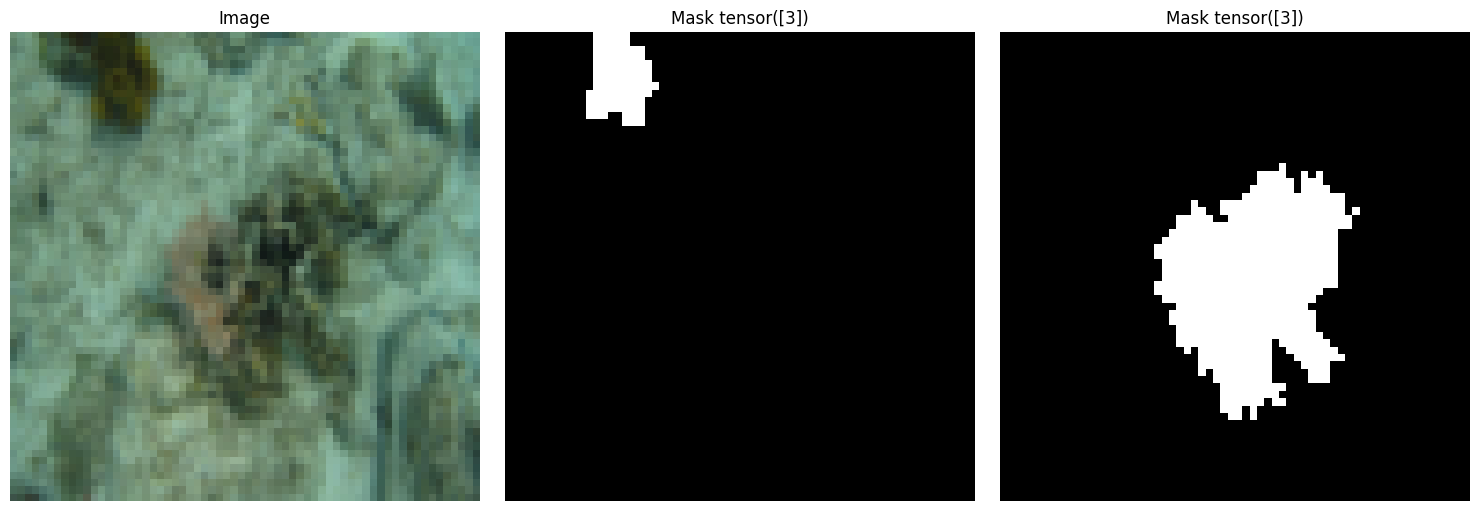

3 3


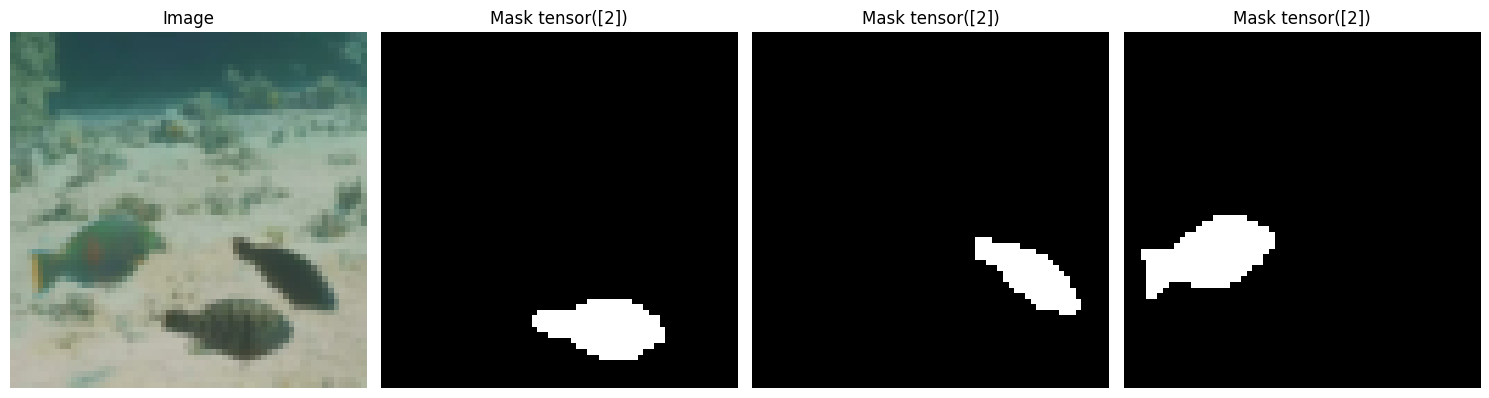

In [50]:
trainloader = data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)

# Train set
for images, masks, ids in trainloader:
    if images is not None:
        show_images_with_masks(images[0], masks, ids)
        break

# Test set
for images, masks, ids in testloader:
    if images is not None:
        show_images_with_masks(images[0], masks, ids)
        break

In [51]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()

In [52]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):# 7 outputs for the 7 different labels
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        out = self.conv_last(d1)

        return out

In [53]:
# Initialize the model
model = UNet().to(device)

In [54]:
pip install torchviz

In [55]:
from torchsummary import summary
from torchviz import make_dot

summary(model, (3, 64, 64))

dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Example input tensor
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters())).render("unet_model", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

'unet_model.png'

In [56]:
# Loss function, and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [57]:
!pip install tensorboard

In [58]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks,ids in trainloader:
        images = images.to(device)
        masks = torch.stack(masks).squeeze(1).to(device)
        ids = torch.tensor(ids).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)


    epoch_loss = running_loss / len(trainloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    writer.add_scalar('Training Loss', epoch_loss, epoch)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ValueError: Target size (torch.Size([2, 1, 64, 64])) must be the same as input size (torch.Size([1, 1, 64, 64]))

In [ ]:
model.eval()
test_running_loss = 0.0
with torch.no_grad():
    for images, masks in testloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        test_running_loss += loss.item() * images.size(0)

test_loss = test_running_loss / len(testloader.dataset)
print(f'Test Loss: {test_loss:.4f}')
writer.add_scalar('Test Loss', test_loss, num_epochs)

writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs